# Predictive Modeling w/ PyTorch
This notebook is a work-in-progress.

- Code to predict stock market movements with large scale technical indicator data used in PyTorch layers.
- Model choice will likely be LSTM but TBD.
- The original data is 'close' pricing and daily 'volume'. These are further extended with many technical indicators.
- The technical indicator data is then pulled for stocks that have close correlations in return with a 'given' input ticker.
- Data for several of these tickers (and their corrs) is then concatenated to construct training dataset.
- In-progress: Further fine-tuning of the initial train/test in PyTorch NN layers

REFERENCE:
- https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [1]:
import os
import os.path
from datetime import datetime
from typing import Any
import time
import numpy as np

import pandas as pd
from pandas.errors import EmptyDataError
from sqlalchemy import create_engine, text
from sklearn.preprocessing import MinMaxScaler

from functools import reduce
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
pd.options.mode.chained_assignment = None

In [2]:
# Setup
BASE_DIR = '../../../../workspace/HelloPython/HistoricalMarketData/TechnicalIndicators'
TABLE_EQUITIES_DATA = 'equities_historic_data'
DURATIONS = (14, 30, 90, 200)  # Roughly for bi-weekly, monthly, quarterly, and 200 days running averages

try:
    DB = os.environ["DB"]
    DB_USER = os.environ["DB_USER"]
    DB_PWD = os.environ["DB_PWD"]
except KeyError:
    raise Exception("Required environment variables DB_USER and DB_PWD not set")
DB_URL = 'mysql+mysqlconnector://' + DB_USER + ':' + DB_PWD + '@localhost/' + DB
ENGINE = create_engine(DB_URL)

In [3]:
def generate_file_path(symbol, date=None):
    """
    Generates a file path for a given symbol
    to retrieve calculated tech indicator data
    from local CSV records
    :param symbol: ticker
    :param date: date embedded in the file name
    :return: file name and path
    """
    if date is not None:
        str_date = datetime.strftime(date, '%Y%m%d')
        file_name = symbol.lower() + '_' + str_date + '.csv'
    else:
        file_name = symbol.lower() + '.csv'
    file_path = os.path.join(BASE_DIR, file_name)
    if file_path is None:
        print('Could not find file for symbol:{}'.format(symbol))
    # print(file_path)
    return file_path, file_name

In [4]:
def retrieve_technical_indicator_data_for_symbol(symbol, columns = None, feature=None)\
        -> Any:
    """
    Retrieves Technical Indicator Data for a given symbol
    for given columns and labels them as Y (dependent) or
    X (input features).
    :param symbol: Symbol for which to retrieve Technical Indicator Data
    :param columns: Subset of Technical Indicator Data to retrieve
    :param feature: Y or X_i label where 'i' is feature number
    :return:
    """
    file_path, _ = generate_file_path(symbol)
    if file_path is not None:
        try:
            dfrm = pd.read_csv(file_path)
            dfrm['date'] = pd.to_datetime(dfrm['date'])
            dfrm.set_index('date', inplace=True)
            dfrm.sort_index(ascending=True)
            dfrm.index.name = 'date'
            if feature is None:
                feature = symbol.upper()
            if columns is not None:
                dfrm = dfrm[columns]
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                if column in columns
                ]
            else:
                dfrm.columns = [
                feature.upper()+'_'+column
                for column in dfrm.columns
                ]
            return dfrm
        except FileNotFoundError as e:
            print('Exception reading input data for symbol {}. Generating metadata starting from baseline date.'.format(symbol.upper()))
            return None
        except EmptyDataError as e:
            print(f'No technical indicators found for {symbol.upper()}. Generating metadata starting from baseline date.')
            print('Generating all records.')
            return None
    else:
        print(f"No technical indicators data in DB for '{symbol}'.")
    return None

# Test
tmp_df = retrieve_technical_indicator_data_for_symbol('AAPL', ['volume', 'close'])
tmp_df.tail(10)

,AAPL_volume,AAPL_close
date,,
2025-04-30,52286454,212.50
2025-05-01,57365675,213.32
2025-05-02,101010621,205.35
2025-05-05,69018452,198.89
2025-05-06,51216482,198.51
2025-05-07,68616943,196.25
2025-05-08,50478872,197.49
2025-05-09,36453923,198.53
2025-05-12,63775814,210.79


In [5]:
def find_symbols_w_highest_correlations(symbol, correlations, count):
    """
    Finds tickers whose return have highest correlation
    with the returns of given symbol
    :param symbol:
    :param correlations:
    :param count:
    :return:
    """
    if len(correlations[correlations['level_0'] == symbol.upper()+'_close']) <= 0:
        print("No correlations found for symbol:{}.".format(symbol.upper()))
        print("Likely data does not go far enough back.")
        return None
    corrs = correlations[correlations['level_0'] == symbol.upper()+'_close']
    corrs.sort_values(0, ascending = False, inplace = True)
    return_symbols = [symbol.replace('_close', '') for symbol in corrs.loc[:,'level_1'].tolist()]
    return return_symbols[:count]

In [6]:
def gen_corrs(dfrm):
    """
    Generate correlations numbers for entire
    input dataframe consisting of daily close values
    :param dfrm:
    :return:
    """
    correlations = dfrm[dfrm.columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    #print(correlations)`
    return correlations

## Training Dataset
Generate training dataset by finding symbols that have the highest correlation (based on daily 'close' values) with the given symbol. Then aggregate their returns over the years. The daily closing price of our target symbol becomes independent variable y and rest of the data including closing values of other symbols and their volumes make up the 'features' or 'X'.

In [7]:
MIN_ROW_COUNT = 5000 # Number of days to retrieve training data for
COMP_COUNT = 10 # Number of stocks to find high correlations with

query = 'SELECT symbol FROM equities_historic_data GROUP BY symbol HAVING COUNT(*) > '+str(MIN_ROW_COUNT)+''
with ENGINE.connect() as conn:
    res = conn.execute(text(query))
dfrm_symbols_list = pd.DataFrame(res.mappings().all())
symbols = dfrm_symbols_list['symbol'].tolist() # this is our universe of symbol tickers

# First calculate universal correlations among ALL these symbols
dfrm_list_daily_closes = list()
for symbol in symbols:
    dfrm = retrieve_technical_indicator_data_for_symbol(symbol, ['close', 'volume'])
    dfrm_list_daily_closes.append(dfrm)
merged_dfrm_daily_close_values = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_daily_closes)
correlations = gen_corrs(merged_dfrm_daily_close_values)

# Now merge a symbol's returns with returns of symbols
# it has the highest correlations with. Then stack (concat)
# all these returns across symbols to come up with our
# training dataset

# Data for a symbol and its corrs matches
# Think of this as a single line in a matrix
dfrm_list_single_row_data = list()
# Data for all symbol and their corrs matches
# Think of this as a matrix
dfrm_list_full_matrix_data = list() # Data for
tgt_symbols_list = ['JPM', 'C', 'MS', 'GS', 'WFC', 'BAC'] # Generate training data for this set only
for symbol in tgt_symbols_list:
    # Our dependent variable Y - generalize the name so we can stack up many symbols for training dataset
    dfrm_symbol = retrieve_technical_indicator_data_for_symbol(symbol, None, 'Y')
    dfrm_list_single_row_data.append(dfrm_symbol)
    symbols_w_highest_corrs = find_symbols_w_highest_correlations(symbol, correlations, COMP_COUNT)
    if symbols_w_highest_corrs is None:
        continue # Likely not enough data for a symbol. Continue with rest
    print(f'Symbols with highest correlations with {symbol.upper()} are {symbols_w_highest_corrs}')
    counter = 1
    for comp_symbol in symbols_w_highest_corrs:
        feature = 'X_'+str(counter)
        dfrm_tmp = retrieve_technical_indicator_data_for_symbol(comp_symbol, None, feature)
        dfrm_list_single_row_data.append(dfrm_tmp)
        counter += 1
    # Now merge the symbol and all its corrs data against the same date
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='date'), dfrm_list_single_row_data)
    dfrm_list_full_matrix_data.append(merged_df)
    dfrm_list_single_row_data.clear()
# Now concatenate data. This means dates are repeated
dfrm_aggr_training_data = pd.concat(dfrm_list_full_matrix_data)

Symbols with highest correlations with JPM are ['TXN', 'PNC', 'MAR', 'SPGI', 'SCHW', 'SIVB', 'SYK', 'WM', 'RJF', 'SNPS']
Symbols with highest correlations with C are ['AIG', 'RF', 'KEY', 'ZION', 'HIG', 'HBAN', 'ARNC', 'FITB', 'KIM', 'XRX']
Symbols with highest correlations with MS are ['HIG', 'DRE', 'ZION', 'KEY', 'FITB', 'LNC', 'MGM', 'RF', 'XRX', 'MET']
Symbols with highest correlations with GS are ['BK', 'STT', 'PRU', 'NTRS', 'CMA', 'CME', 'LNC', 'CBRE', 'SCHW', 'PFG']
Symbols with highest correlations with WFC are ['USB', 'DIS', 'PPG', 'UPS', 'SNA', 'IPG', 'OMC', 'MDLZ', 'AMGN', 'WHR']
No correlations found for symbol:BAC.
Likely data does not go far enough back.


In [54]:
dfrm_single_symbol_training_data = dfrm_list_full_matrix_data[0]
# Avoid null values
dfrm_single_symbol_training_data = dfrm_single_symbol_training_data[~dfrm_single_symbol_training_data.isnull().any(axis=1)]
dfrm_single_symbol_training_data

,Y_symbol,Y_close,Y_volume,Y_mean_200,Y_stddev_200,Y_pcntleStdDevs_200,Y_pcntleVolume_200,Y_pcntleClosing_200,Y_oscillator_200,Y_accu_dist_200,...,X_10_stddev_90,X_10_accu_dist_200,X_10_bollingerLower_200,X_10_bollingerUpper_200,X_10_mean_200,X_10_oscillator_200,X_10_pcntleClosing_200,X_10_pcntleStdDevs_200,X_10_pcntleVolume_200,X_10_stddev_200
date,,,,,,,,,,,,,,,,,,,,,
2002-09-09,JPM,23.59,23680000,31.776978,4.705188,100.000000,97.122302,4.316547,19.190815,-6.518780e+06,...,2.486891,-1.026917e+06,19.785965,28.605158,24.195561,33.779744,24.460432,100.000000,74.100719,2.204798
2002-09-10,JPM,23.15,11270000,31.733885,4.756663,100.000000,71.223022,3.597122,16.785128,-7.035435e+06,...,2.475882,-5.645153e+05,19.783901,28.605423,24.194662,41.013990,30.215827,100.000000,69.064748,2.205381
2002-09-11,JPM,22.98,6950000,31.696403,4.805072,100.000000,21.223022,3.597122,15.855659,-7.139901e+06,...,2.455101,-3.469100e+05,19.780355,28.605372,24.192863,44.481645,34.172662,100.000000,71.942446,2.206254
2002-09-12,JPM,22.01,11700000,31.627214,4.857242,100.000000,75.000000,1.428571,10.552214,-8.255914e+06,...,2.442712,-9.124217e+05,19.770130,28.587841,24.178986,35.453785,25.000000,97.857143,32.142857,2.204428
2002-09-13,JPM,22.04,10830000,31.559220,4.906746,100.000000,66.666667,2.127660,10.716238,-8.223624e+06,...,2.422584,-8.085136e+05,19.762802,28.569723,24.166262,37.068038,27.304965,97.163121,14.184397,2.201730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-18,JPM,148.97,8517460,140.885000,8.321955,55.714286,28.571429,82.857143,72.710789,5.394542e+06,...,14.678037,2.931939e+05,328.429070,473.456073,400.942571,66.237495,60.714286,75.000000,52.142857,36.256751
2023-08-21,JPM,149.48,8327018,140.976087,8.411650,58.695652,25.362319,82.608696,74.252040,5.786369e+06,...,13.870644,4.477079e+05,330.107756,474.207462,402.157609,74.786629,73.913043,70.289855,26.086957,36.024927
2023-08-22,JPM,146.38,9681972,141.030000,8.422340,59.420290,46.376812,77.536232,64.883651,3.546520e+06,...,12.516317,4.455016e+05,330.596677,474.701149,402.648913,74.715505,73.188406,70.289855,33.333333,36.026118


## Data Normalization and Train-Test split

In [55]:
# Start with separating features (independent vector matrix X) and dependent vector (y)
batch_size = 5
len_data = len(dfrm_single_symbol_training_data)
tgt_field_column_name = 'Y_close'
tgt_symbol_column_name = 'Y_symbol'
train_to_total_ratio = 0.8

p = int(train_to_total_ratio * dfrm_single_symbol_training_data.shape[0])
# The train and test dataset must be perfect multiple of batch size
p = p - p % batch_size # Align train set length to batch size
q = dfrm_single_symbol_training_data.shape[0] - p
q = q - q % batch_size # Align test set length to batch size
dfrm_training = dfrm_single_symbol_training_data[:p]
dfrm_test = dfrm_single_symbol_training_data[p:p+q] # Last few test samples are skipped
print(len(dfrm_training))
print(len(dfrm_test))

4065
1015


In [100]:
# x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'symbol' not in column]
x_columns = [column for column in dfrm_training.columns if column not in [tgt_field_column_name] and 'close' in column]
Y_train = dfrm_training[tgt_field_column_name]
X_train = dfrm_training[x_columns]
# null_indices = X_train[X_train.isnull().any(axis=1)].index
# X_train = X_train.drop(null_indices)
# Y_train = Y_train.drop(null_indices)

Y_test = dfrm_test[tgt_field_column_name]
X_test = dfrm_test[x_columns]

# Scale the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
transformed_Y_train = scaler_y.fit_transform(Y_train.values.reshape(-1,1))
transformed_Y_test = scaler_y.transform(Y_test.values.reshape(-1,1))

# Scale the features
scaler_x = MinMaxScaler(feature_range=(-1, 1))
transformed_X_train = scaler_x.fit_transform(X_train)
transformed_X_test = scaler_x.transform(X_test)

In [101]:
X_train

,X_1_close,X_2_close,X_3_close,X_4_close,X_5_close,X_6_close,X_7_close,X_8_close,X_9_close,X_10_close
date,,,,,,,,,,
2002-09-09,19.91,47.00,15.551,31.51,9.80,22.40,29.305,25.40,12.800,22.110
2002-09-10,20.48,46.14,15.655,31.98,10.08,21.76,29.125,25.34,12.849,22.715
2002-09-11,20.65,46.15,15.278,31.69,10.02,21.85,29.400,25.45,12.822,23.005
2002-09-12,19.21,45.32,14.726,31.10,9.45,21.59,28.805,25.29,12.511,22.250
2002-09-13,19.00,44.80,14.703,31.49,10.01,21.34,28.745,25.22,12.644,22.385
...,...,...,...,...,...,...,...,...,...,...
2018-12-04,96.11,129.51,113.500,177.62,43.01,240.43,172.250,92.62,76.250,89.450
2018-12-05,96.11,129.51,113.500,177.62,43.01,240.43,172.250,92.62,76.250,89.450
2018-12-06,97.32,129.31,115.320,173.49,42.60,219.15,172.440,92.86,77.480,91.190


In [102]:
x_train = torch.from_numpy(transformed_X_train).to(torch.float32)
x_test = torch.from_numpy(transformed_X_test).to(torch.float32)
y_train = torch.from_numpy(transformed_Y_train).to(torch.float32)
y_test = torch.from_numpy(transformed_Y_test).to(torch.float32)

# training_dataset_torch = torch.from_numpy(dfrm_training).to(torch.float32)
# test_dataset_torch = torch.from_numpy(dfrm_test).to(torch.float32)

# Create a dataset and data loader
train_dataset = TensorDataset(x_train.unsqueeze(1), y_train)  # Add sequence dimension
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

test_dataset = TensorDataset(x_test.unsqueeze(1), y_test)  # Add sequence dimension
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [103]:
x_train.shape

torch.Size([4065, 10])

In [104]:
# Dimensions for data input
input_dim = len(X_train.columns) # Number of features
#hidden_dim = int(len(X_train)) # Number of samples or units
hidden_dim = 512
num_layers = 2
output_dim = 1
num_epochs = 3 # Intentionally keeping low for initial debugging
seq_len = 10

## Model Definition and Predictions

In [105]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure x has batch dimension
        #print("Input size:", x.size(0))
        # print(f'X:{x}')
        x = self.dropout(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [106]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers= num_layers, output_dim=output_dim, )
criterion = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
model.lstm

LSTM(10, 512, num_layers=2, batch_first=True)

## Model Training and Evaluation

In [107]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    counter = 1
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.reshape(5, -1, input_dim)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if counter % 100 == 0:
            print(f'Epoch:{t:}, Batch:{counter}, Loss: {loss.item():.4f}')
        counter += 1
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:0, Batch:100, Loss: 0.0622
Epoch:0, Batch:200, Loss: 0.0232
Epoch:0, Batch:300, Loss: 0.0364
Epoch:0, Batch:400, Loss: 0.0171
Epoch:0, Batch:500, Loss: 0.0324
Epoch:0, Batch:600, Loss: 0.0007
Epoch:0, Batch:700, Loss: 0.0033
Epoch:0, Batch:800, Loss: 0.2182
Epoch:1, Batch:100, Loss: 0.0442
Epoch:1, Batch:200, Loss: 0.0470
Epoch:1, Batch:300, Loss: 0.1475
Epoch:1, Batch:400, Loss: 0.0186
Epoch:1, Batch:500, Loss: 0.0116
Epoch:1, Batch:600, Loss: 0.0119
Epoch:1, Batch:700, Loss: 0.0408
Epoch:1, Batch:800, Loss: 0.2461
Epoch:2, Batch:100, Loss: 0.0109
Epoch:2, Batch:200, Loss: 0.0058
Epoch:2, Batch:300, Loss: 0.0893
Epoch:2, Batch:400, Loss: 0.0212
Epoch:2, Batch:500, Loss: 0.0117
Epoch:2, Batch:600, Loss: 0.0054
Epoch:2, Batch:700, Loss: 0.0145
Epoch:2, Batch:800, Loss: 0.3934
Training time: 42.43901968002319


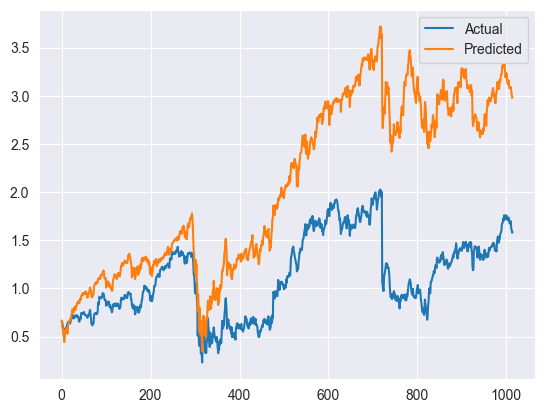

In [108]:
# Make predictions on the test dataset
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        test_labels.extend(labels.cpu().numpy().flatten()) # Add observed values to list
        inputs = inputs.reshape(5, -1, input_dim)
        outputs = model(inputs)
        test_preds.extend(outputs.cpu().numpy().flatten()) # Add predicted values to list

# Plot predictions against actual values
plt.plot(test_labels, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.legend()
plt.show()
